# Unidad 4: Introducción a los modelos de pronóstico

## 2.1 Introducción

Abordaremos métodos de suavizamiento, buscando la aproximación cuantitativa del pronóstico de series temporales.

## 2.2 Objetivo

Conocer los modelos básicos de series de tiempo usando las técnicas apropiadas y comunes para ejemplificar las relaciones entre este tipo de datos. 

## 2.3 Acción

En esta ocasión, se debe aplicar la metodología Holter-Winter y de suavizamiento a la variable tiempo.  Se invita al estudiante en ser claro en sus procedimientos, ya que la forma de justificarlos será evaluada

### 2.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

#  remuestreando el dataframe a mensual
df_vcm = df_vcm.resample('M',on='fechaoperacion').mean().reset_index()
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


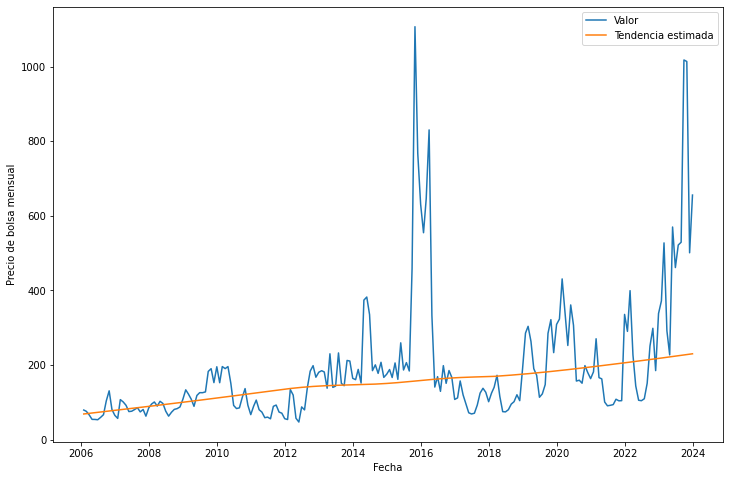

2006-01-31      79.026486
2006-02-28      75.520919
2006-03-31      65.787447
2006-04-30      54.012347
2006-05-31      53.819582
                 ...     
2023-08-31     528.887237
2023-09-30    1017.549693
2023-10-31    1013.522208
2023-11-30     500.608645
2023-12-31     655.417696
Freq: M, Length: 216, dtype: float64


In [6]:
# Graficar la serie de tiempo y su tendencia estimada
plt.figure(figsize=(12, 8))
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Valor')
lowess = sm.nonparametric.lowess
smoothed = lowess(df_vcm['valor'], df_vcm['fechaoperacion'])
plt.plot(df_vcm['fechaoperacion'], smoothed[:, 1], label='Tendencia estimada')
plt.xlabel('Fecha')
plt.ylabel('Precio de bolsa mensual')
plt.legend()
plt.show()

# Crear una serie temporal
Ventas_ts = pd.Series(df_vcm['valor'].values, index=pd.date_range(start='2006-01', periods=len(df_vcm), freq='M'))
print(Ventas_ts)

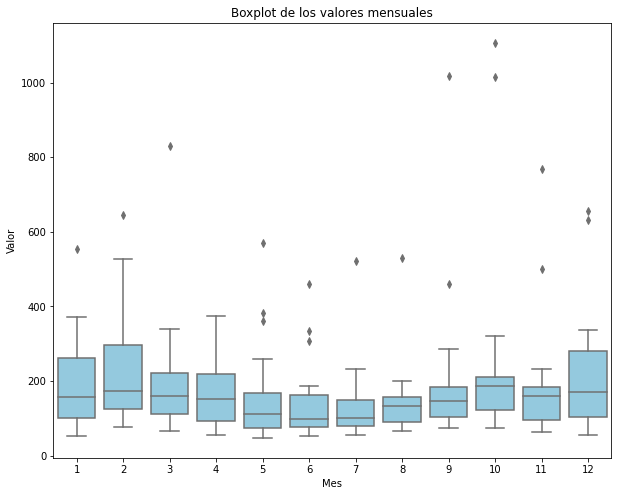

In [17]:
# Crear un boxplot de los datos
plt.figure(figsize=(10, 8))
sns.boxplot(x=Ventas_ts.index.month, y=Ventas_ts.values,color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Valor')
plt.title('Boxplot de los valores mensuales')
plt.show()

c:\Users\uenergia\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


{'smoothing_level': 0.8790051179983391, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.0, 'damping_trend': nan, 'initial_level': 5.015545342915327, 'initial_trend': 0.010128656223691891, 'initial_seasons': array([-0.68742447, -0.47861175, -0.65459621, -0.82284567, -0.93725023,
       -1.01693852, -1.07559504, -0.95396906, -0.73663761, -0.58885816,
       -0.82288391, -0.73055972]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


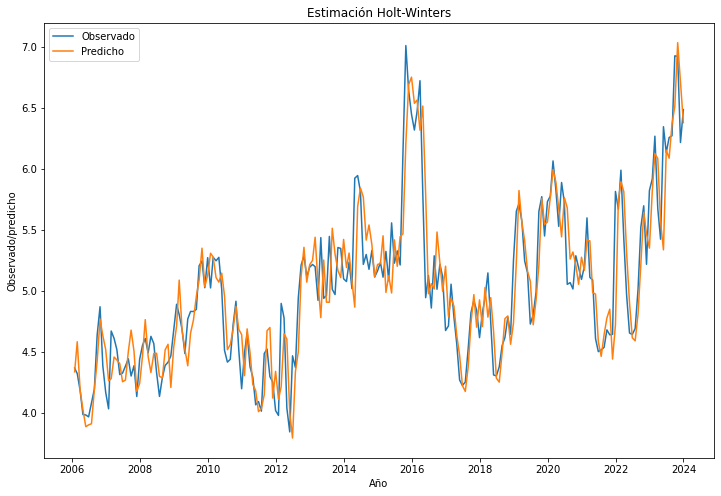

In [7]:
# Estabilización de la variabilidad
VentasLog = np.log(Ventas_ts)

# Aplicación del método Holt-Winters
model = ExponentialSmoothing(VentasLog, seasonal_periods=12, trend='add', seasonal='add')
fit = model.fit()

# Imprimir los parámetros del modelo
print(fit.params)

# Graficar los resultados
plt.figure(figsize=(12, 8))
plt.plot(VentasLog, label='Observado')
plt.plot(fit.fittedvalues, label='Predicho')
plt.title("Estimación Holt-Winters")
plt.xlabel('Año')
plt.ylabel('Observado/predicho')
plt.legend()
plt.show()

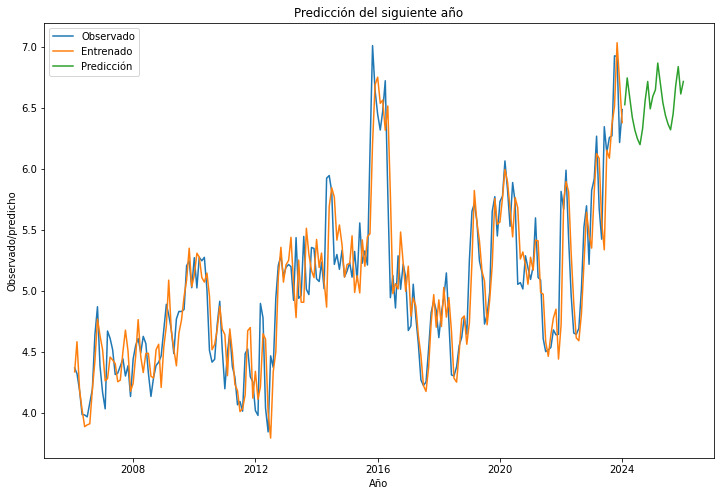

In [12]:
# Predicción del siguiente año
forecast_next_year = fit.forecast(steps=24)

# Graficar la predicción
plt.figure(figsize=(12, 8))
plt.plot(VentasLog, label='Observado')
plt.plot(fit.fittedvalues, label='Entrenado')
plt.plot(pd.date_range(start='2024-01', periods=24, freq='M'), forecast_next_year, label='Predicción')
plt.title("Predicción del siguiente año")
plt.xlabel('Año')
plt.ylabel('Observado/predicho')
plt.legend()
plt.show()

In [18]:
forecast_next_year

2024-01-31    6.525577
2024-02-29    6.744519
2024-03-31    6.578663
2024-04-30    6.420542
2024-05-31    6.316266
2024-06-30    6.246707
2024-07-31    6.198179
2024-08-31    6.329933
2024-09-30    6.557393
2024-10-31    6.715302
2024-11-30    6.491404
2024-12-31    6.593857
2025-01-31    6.647121
2025-02-28    6.866063
2025-03-31    6.700207
2025-04-30    6.542086
2025-05-31    6.437810
2025-06-30    6.368250
2025-07-31    6.319723
2025-08-31    6.451477
2025-09-30    6.678937
2025-10-31    6.836845
2025-11-30    6.612948
2025-12-31    6.715401
Freq: M, dtype: float64

In [19]:
predict_pbna = np.exp(forecast_next_year)
predict_pbna

2024-01-31    682.373632
2024-02-29    849.390244
2024-03-31    719.576564
2024-04-30    614.336073
2024-05-31    553.502477
2024-06-30    516.309602
2024-07-31    491.852430
2024-08-31    561.119201
2024-09-30    704.433175
2024-10-31    824.932507
2024-11-30    659.448899
2024-12-31    730.593582
2025-01-31    770.562856
2025-02-28    959.164513
2025-03-31    812.573854
2025-04-30    693.732197
2025-05-31    625.036534
2025-06-30    583.036892
2025-07-31    555.418901
2025-08-31    633.637634
2025-09-30    795.473350
2025-10-31    931.545885
2025-11-30    744.675356
2025-12-31    825.014700
Freq: M, dtype: float64

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Selecciona un conjunto de datos de prueba
test_data = VentasLog[-12:]  # Supongamos que los últimos 12 meses son el conjunto de prueba

# Realiza la predicción para estos datos de prueba
forecast_next_year = fit.forecast(steps=12)

# Calcula el Error Cuadrático Medio (MSE)
mse = mean_squared_error(test_data, forecast_next_year)

# Calcula el Error Absoluto Medio (MAE)
mae = mean_absolute_error(test_data, forecast_next_year)

print("Error Cuadrático Medio (MSE):", mse)
print("Error Absoluto Medio (MAE):", mae)

Error Cuadrático Medio (MSE): 0.22430213960370213
Error Absoluto Medio (MAE): 0.35016947773733853
